Example of generation of one dimentional gaussian process 
and fitting by cosmogp (without error for the moment)

In [1]:
import cosmogp
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

np.random.seed(1)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### Generation of gaussian process (2D and centred):

$Y\left(\textbf{X} \right) \sim {\cal N}\left(0,\textbf{K}\right)$ 

Where $\textbf{K}$ is the Kernel define like you want. In this peculiar cas it will be define as a Radial Basis Function (RBF) :


$K_{\textbf{X}_i \ \textbf{X}_j}=\sigma^2 \ \exp\left[-\frac{1}{2} \left(\textbf{X}_i - \textbf{X}_j\right)^T \textbf{L}^{-1} \left(\textbf{X}_i - \textbf{X}_j\right)\right]$

where $\textbf{L}$ is define as : 

$ \textbf{L} = \ \begin{pmatrix} l_x^2 &   &l_{xy} \\ l_{xy}  &  & l_y^2 \end{pmatrix} $


$\sigma$, $l_x$, $l_y$, $l_{xy}$ are the Kernel hyperparameter and the goal will be to fit them. $\sigma$ represent the standard deviation from the mean (0 here) and $\textbf{L}$ represent how the data are correlated within the 2D space.

In this example $\sigma=0.5$ and $l_x=2$, $l_y=2$, $l_{xy}=0.5$


In [2]:
n_object = 30 # number of object to fit
n_point = 10 # sqrt(number of points) per object

x1 = np.linspace(-10,10,n_point) # x1 coordinate 
x2 = np.linspace(-10,10,n_point) # x2 coordinate 

X1,X2 = np.meshgrid(x1,x2) # x1,x2 2d grid 

X = np.zeros((n_point**2,2)) # fixed grid where gp will be generated

X[:,0] = X1.reshape((1,len(X1)**2))[0]
X[:,1] = X2.reshape((1,len(X2)**2))[0]

K = cosmogp.rbf_kernel_2d(X,np.array([0.5,2.,2.,0.5]),0.) # build the kernel with fixed hyperparameter

Y = np.random.multivariate_normal(np.zeros(n_point**2), K,size=n_object) # generation of gaussian process
    

How looks like one 2D gaussian process :

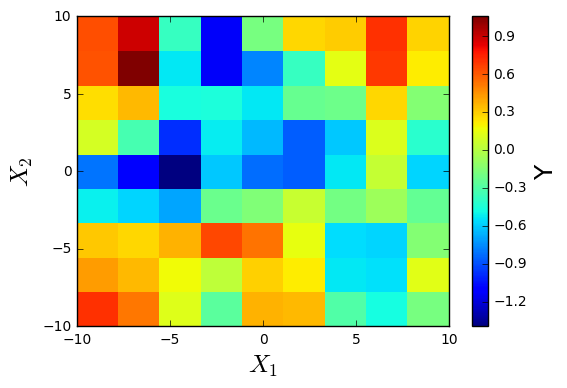

In [3]:
y=np.zeros((n_object,n_point,n_point))   
for image in range(n_object): # make grid
    t=0                                                                                                                                       
    for i in range(n_point):    
        for j in range(n_point):
            y[image,i,j]=Y[image,t]
            t+=1           
            
plt.pcolor(X1, X2, y[0],cmap=plt.cm.jet) 
plt.xlabel('$X_1$',fontsize=18)
plt.ylabel('$X_2$',fontsize=18)
cb = plt.colorbar()
cb.set_label('Y',fontsize=18)

Now cosmogp will fit hyperparameter for the first object by doing :

In [4]:
gp = cosmogp.gaussian_process(Y[0],X,kernel='RBF2D') # init cosmogp with one object                                                                                                                                                                                                   
gp.find_hyperparameters(hyperparameter_guess=[0.5,2,2,0.5], nugget=False, SVD=True) #search hyperparameter

The set of hyperparameter is given by :

In [5]:
print gp.hyperparameters

[0.5051606723561648, 2.1174475631968566, 2.264328924690834, 0.244067539708716]


And you get your interpolation and the covariance error matrix by doing the following command line. The result is inside the plot.

In [6]:
N = 50

new_grid = np.linspace(-10,10,N)
new_grid1,new_grid2= np.meshgrid(new_grid,new_grid)

NEW_GRID = np.zeros((N**2,2)) # fixed grid where gp will be generated

NEW_GRID[:,0] = new_grid1.reshape((1,N**2))[0]
NEW_GRID[:,1] = new_grid2.reshape((1,N**2))[0]

gp.get_prediction(new_binning=NEW_GRID) # get interpolation 

prediction=gp.Prediction[0].reshape((N,N))

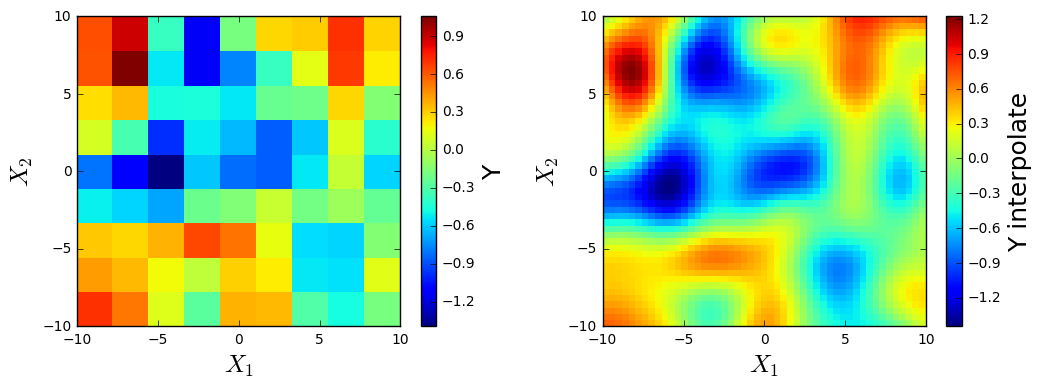

In [7]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.3)
plt.pcolor(X1, X2, y[0],cmap=plt.cm.jet) 
plt.xlabel('$X_1$',fontsize=18)
plt.ylabel('$X_2$',fontsize=18)
cb = plt.colorbar()
cb.set_label('Y',fontsize=18)
plt.subplot(1,2,2)
plt.pcolor(new_grid1,new_grid2, prediction,cmap=plt.cm.jet) 
plt.xlabel('$X_1$',fontsize=18)
plt.ylabel('$X_2$',fontsize=18)
cb = plt.colorbar()
cb.set_label('Y interpolate',fontsize=18)

This is possible to do the fit with cosmogp for all the gaussian process generated, and to look distribution of hyperparameters and the pull. If the cosmogp works well it should find a gaussian distribution with a standrad deviation of 1. The pull for a given point will be define as:

$\text{pull}_{X_i }= \frac{y_{\lambda n t_i}' - y_{\lambda n t_i}}{\sqrt{\text{cov}\left(\textbf{y}'_{ii}\right)}}$

where $y_i$ is your initial dataset at the postion $x_i$, $y_i'$ your interpolation value at the position $x_i$ without taking into account the contribution of $y_i$ in the computation of itself, and $\text{cov}\left(\textbf{y}'_{ii}\right)$ is the diagonal part of the error on the intepolation at the position $X_i$




In [8]:
hyperparmeter_sigma = np.zeros(n_object)
hyperparmeter_lx = np.zeros(n_object)
hyperparmeter_ly = np.zeros(n_object)
hyperparmeter_lxy = np.zeros(n_object)

pull = np.zeros(np.shape(Y))


for i in range(n_object):
    
    gp = cosmogp.gaussian_process(Y[i],X,kernel='RBF2D') # init cosmogp with one object 
    gp.find_hyperparameters(hyperparameter_guess=[0.5,2,2,0.5]) # search hyperparameters 
    
    hyperparmeter_sigma[i] = gp.hyperparameters[0]
    hyperparmeter_lx[i] = gp.hyperparameters[1]
    hyperparmeter_ly[i] = gp.hyperparameters[2]
    hyperparmeter_lxy[i] = gp.hyperparameters[3]
    
    bp = cosmogp.build_pull([Y[i]],[X],gp.hyperparameters,kernel='RBF2D')                                           
    bp.compute_pull(diff=None,svd=True)
    pull[i] = bp.pull

    

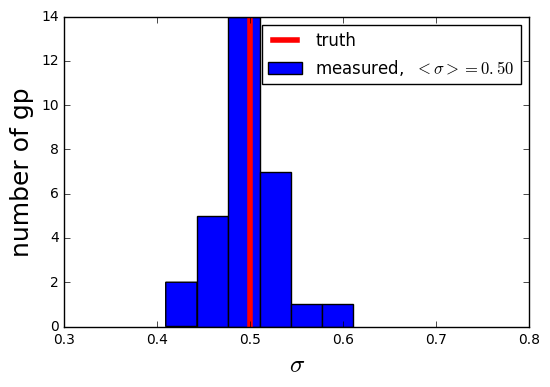

In [9]:
plt.figure()
plt.hist(hyperparmeter_sigma,bins=6,label='measured,  $<\sigma>=%.2f$'%np.mean(hyperparmeter_sigma))
plt.plot([0.5,0.5],[0,14],'r',linewidth=4,label='truth')
plt.xlabel('$\sigma$',fontsize=18)
plt.ylabel('number of gp',fontsize=18)
plt.xlim(0.3,0.8)
plt.legend()

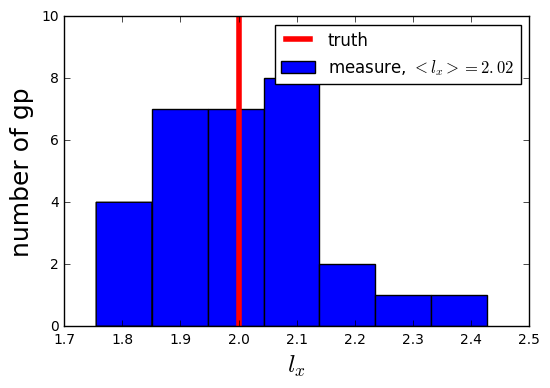

In [10]:
plt.figure()
plt.hist(hyperparmeter_lx,bins=7,label='measure, $<l_x>=%.2f$'%np.mean(hyperparmeter_lx))
plt.plot([2,2],[0,10],'r',linewidth=4,label='truth')
plt.xlabel('$l_x$',fontsize=18)
plt.ylabel('number of gp',fontsize=18)
plt.legend(loc=1)

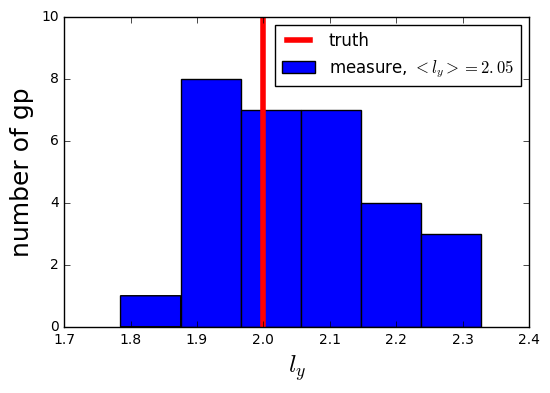

In [11]:
plt.figure()
plt.hist(hyperparmeter_ly,bins=6,label='measure, $<l_y>=%.2f$'%np.mean(hyperparmeter_ly))
plt.plot([2,2],[0,10],'r',linewidth=4,label='truth')
plt.xlabel('$l_y$',fontsize=18)
plt.ylabel('number of gp',fontsize=18)
plt.legend(loc=1)

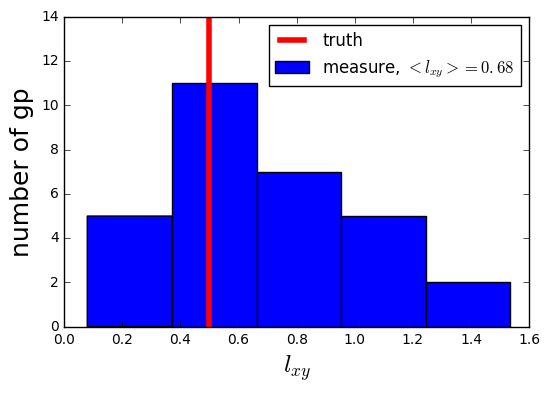

In [12]:
plt.figure()
plt.hist(hyperparmeter_lxy,bins=5,label='measure, $<l_{xy}>=%.2f$'%np.mean(hyperparmeter_lxy))
plt.plot([0.5,0.5],[0,14],'r',linewidth=4,label='truth')
plt.xlabel('$l_{xy}$',fontsize=18)
plt.ylabel('number of gp',fontsize=18)
plt.legend(loc=1)

(-5, 5)

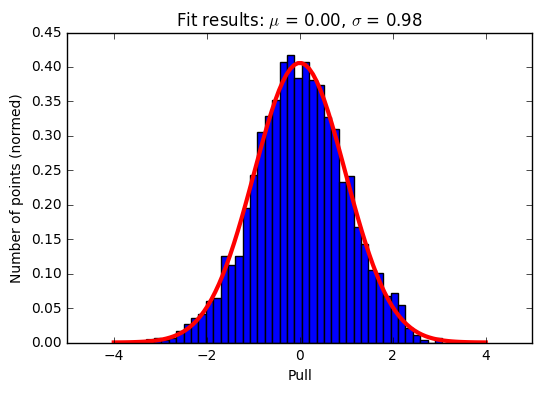

In [13]:
pull = pull.reshape((n_object*n_point**2,1))

from scipy.stats import norm as normal
average_pull, std_pull = normal.fit(pull)

plt.hist(pull,bins=40,normed=True)
xmin, xmax = plt.xlim()
X = np.linspace(xmin, xmax, 100)
PDF = normal.pdf(X, average_pull, std_pull)
plt.plot(X, PDF, 'r', linewidth=3)
title = r"Fit results: $\mu$ = %.2f, $\sigma$ = %.2f" % (average_pull, std_pull)
    
plt.title(title)
plt.ylabel('Number of points (normed)')
plt.xlabel('Pull')

plt.xlim(-5,5)